In [75]:
from docopt import docopt
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob

class omr:
    """
    Optical Music Recognition class
    """
    sobel_sx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]]) 
    sobel_sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) 
    
    sobel_separable_x = np.array([[1,0,-1]])
    sobel_separable_y = np.array([[1,2,1]])
    
    def __init__(self, img_name, img_location=".", with_test=False) -> None:
        """
        Constructor method
        Args:
            img_name (str): name of the image. ex. music1.png
            img_location (str, optional): Location of the image. Defaults to "."
                                          ex. ./test-images
            with_test (bool, optional): Compare with standard libraries. 
                                        Defaults to False.
        """
        self.img_name = img_name
        self.img_file = Path(img_location, img_name)
        self.with_test = with_test
        self.img_obj = Image.open(self.img_file).convert("L")
        # self.img_obj.show()
        self.img_array = np.asarray(self.img_obj)
        self.img_width = self.img_obj.width
        self.img_height = self.img_obj.height
        print(f"INFO: Loaded {self.img_name} as an array of shape {self.img_array.shape}")

    def convolve(self, kernel):
        """
        Method to perform 2D convolution of self.img_array and kernel.

        Args:
            kernel (np.Array): Kernel to used for the convolution.

        Return:
            Array resulted after the convolution having shape same as input 
            image array.
        """
        kernel_rows, kernel_cols = kernel.shape
        img_rows, img_cols = self.img_array.shape

        # flip the kernel
        flipped_kernel = np.zeros(kernel.shape)    
        ## column flips
        for i in range(flipped_kernel.shape[1]):
            flipped_kernel[:,i] = kernel[:,kernel_cols-i-1]
        kernel = flipped_kernel.copy()
        ## row flips
        for i in range(flipped_kernel.shape[0]):
            flipped_kernel[i,:] = kernel[kernel_rows-i-1,:]
        kernel = flipped_kernel.copy()

        # Handle broders by padding the image with white pixels.
        padwidth = kernel_rows // 2
        self.img_array_padded = np.pad(self.img_array, padwidth, 
                                    mode='constant', constant_values=255)
        
        # cross correlation
        self.img_array_out = np.zeros(self.img_array.shape)

        for y in range(img_cols):
            for x in range(img_rows):
                self.img_array_out[x, y] = \
                (kernel * self.img_array_padded[x:x+kernel_cols, y:y+kernel_rows]).sum()

        return self.img_array_out

    def separable_convolve(self, h_kernel, v_kernel):
        """
        Method to perform 2D convolution in the horizontal and then vertical direction of self.img_array and kernel.
        Args:
            h_kernel (np.Array): Kernel used in the horizontal direction for the convolution.
            v_kernel (np.Array): Kernel used in the vertical direction for the convolution.
        Return:
            Array resulted after the convolution having shape same as input 
            image array.
        """
        kernel_rows, kernel_cols = h_kernel.shape
        img_rows, img_cols = self.img_array.shape

        # Handle broders by padding the image with white pixels.
        padwidth = kernel_cols // 2
        self.img_array_padded = np.pad(self.img_array, padwidth, 
                                    mode='constant', constant_values=255)
        
        # convoution in the horizontal direction
        self.img_array_out_tmp = np.zeros((self.img_array.shape[0]+h_kernel.shape[1]-1, self.img_array.shape[1]))
        for y in range(img_cols):
            for x in range(img_rows+h_kernel.shape[1]-1):
                self.img_array_out_tmp[x, y] = \
                (h_kernel * self.img_array_padded[x, y:y+h_kernel.shape[1]]).sum()

        # convoution in the horizontal direction
        self.img_array_out = np.zeros(self.img_array.shape)

        for y in range(img_cols):
            for x in range(img_rows):
                self.img_array_out[x, y] = \
                (v_kernel * self.img_array_out_tmp[x:x+v_kernel.shape[1], y]).sum()
        
#         print("Convolved image:\n", self.img_array_out.shape)
        return self.img_array_out
    
    def edge_detect_sobel(self, figsize=(10,8)):
        """
        Method to perform edge detection using sobel operator and 2D convolution
        """
        self.convolved_x = self.convolve(omr.sobel_sx)
        self.convolved_y = self.convolve(omr.sobel_sy)
        self.edge_map = np.sqrt(self.convolved_x**2 + self.convolved_y**2)
        
        if self.with_test:
            fig, axs = plt.subplots(2, 2, figsize=figsize)
            axs[0,0].imshow(self.img_array, 'gray')
            axs[0,0].set_title("Original image")
            axs[0,1].imshow(self.edge_map, 'gray')
            axs[0,1].set_title("Edge map of image")
            axs[1,0].imshow(self.convolved_x, 'gray')
            axs[1,0].set_title("Sobel_X convolution")
            axs[1,1].imshow(self.convolved_y, 'gray')
            axs[1,1].set_title("Sobel_Y convolution")
            
        return self.edge_map
    
    def edge_detect_sobel_separable(self, figsize=(10,8)):
        """
        Method to perform edge detection using sobel operator and separable kernel convolutions
        """
        self.convolved_separable_x = self.separable_convolve(omr.sobel_separable_x,omr.sobel_separable_y)
        self.convolved_separable_y = self.separable_convolve(omr.sobel_separable_y,omr.sobel_separable_x)
        self.edge_map_separable = np.sqrt(self.convolved_separable_x**2 + self.convolved_separable_y**2)
        
        if self.with_test:
            fig, axs = plt.subplots(2, 2, figsize=figsize)
            axs[0,0].imshow(self.img_array, 'gray')
            axs[0,0].set_title("Original image")
            axs[0,1].imshow(self.edge_map_separable, 'gray')
            axs[0,1].set_title("Edge map of image (separable cov)")
            axs[1,0].imshow(self.convolved_separable_x, 'gray')
            axs[1,0].set_title("Sobel_X separable convolution")
            axs[1,1].imshow(self.convolved_separable_y, 'gray')
            axs[1,1].set_title("Sobel_Y separable convolution")
        
        return self.edge_map_separable


    
    
    
    
    
            

## Edge detection demo using separable convolution on all available images 

test-images\music1.png
INFO: Loaded test-images\music1.png as an array of shape (231, 1274)
test-images\music2.png
INFO: Loaded test-images\music2.png as an array of shape (382, 1435)
test-images\music3.png
INFO: Loaded test-images\music3.png as an array of shape (496, 1203)
test-images\music4.png
INFO: Loaded test-images\music4.png as an array of shape (396, 1818)
test-images\rach.png
INFO: Loaded test-images\rach.png as an array of shape (2480, 1824)
test-images\template1.png
INFO: Loaded test-images\template1.png as an array of shape (11, 17)
test-images\template2.png
INFO: Loaded test-images\template2.png as an array of shape (35, 16)
test-images\template3.png
INFO: Loaded test-images\template3.png as an array of shape (29, 18)


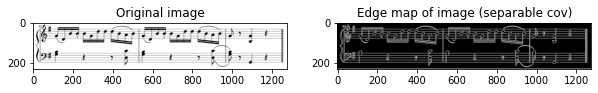

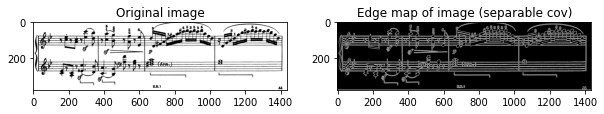

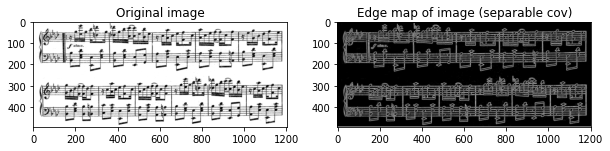

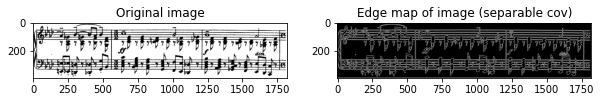

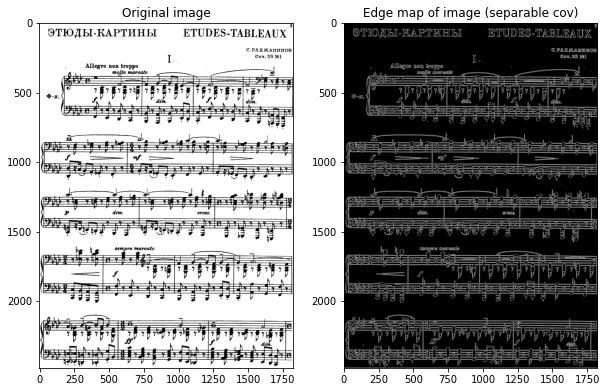

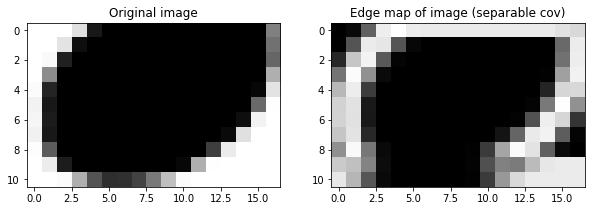

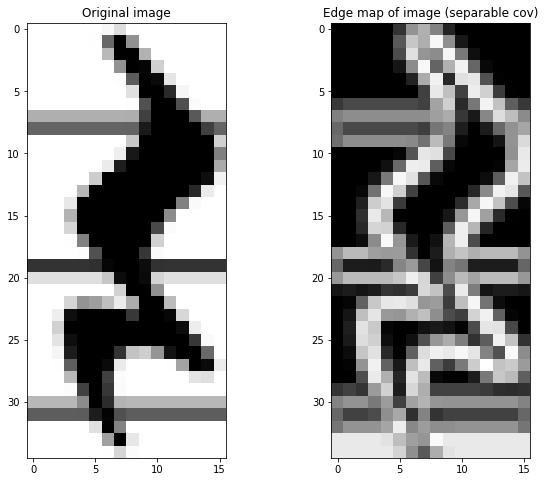

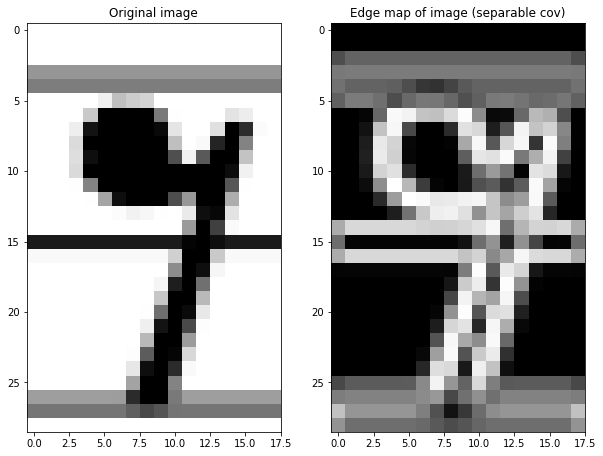

In [74]:
for img in glob("test-images\*.png"):
#     print(img)
    omr_obj = omr(img)
    fig, axs = plt.subplots(1, 2, figsize=(10,8))
    axs[0].imshow(omr_obj.img_array, 'gray')
    axs[0].set_title("Original image")
    axs[1].imshow(omr_obj.edge_detect_sobel_separable(), 'gray')
    axs[1].set_title("Edge map of image (separable cov)")
    

## Compare edge maps generated by 2D convolution with separable convolution
* Edge maps don't match exactly. Should be checked further

INFO: Loaded test-images\template1.png as an array of shape (11, 17)


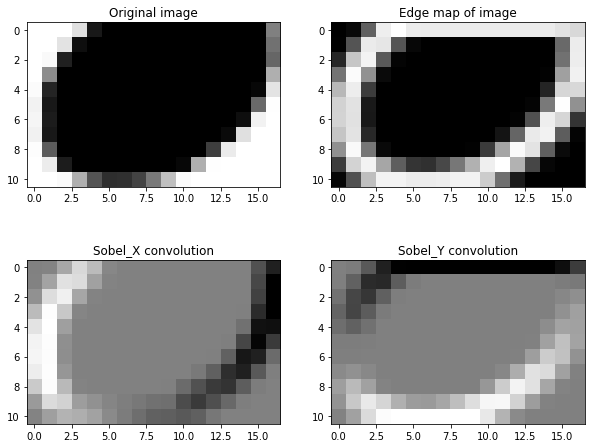

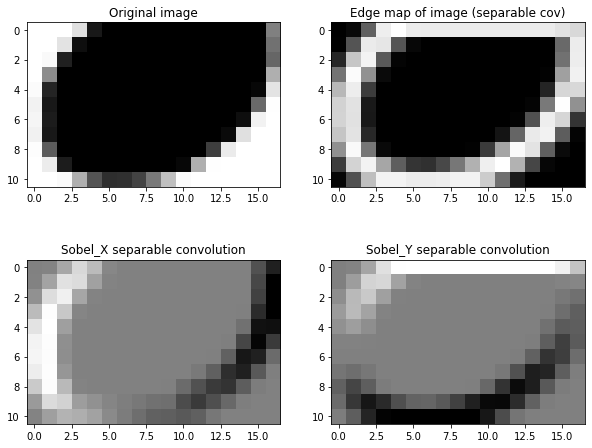

In [76]:
img_name = r"test-images\template1.png"
omr_obj = omr(img_name, with_test=True)
_ = omr_obj.edge_detect_sobel()
_ = omr_obj.edge_detect_sobel_separable()

INFO: Loaded test-images\music1.png as an array of shape (231, 1274)
Convolved image:
 (231, 1274)
Convolved image:
 (231, 1274)


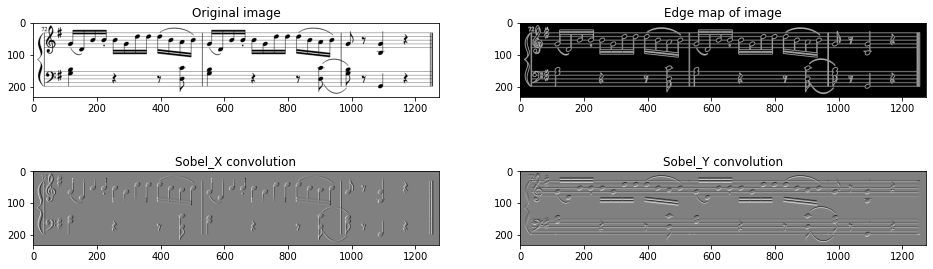

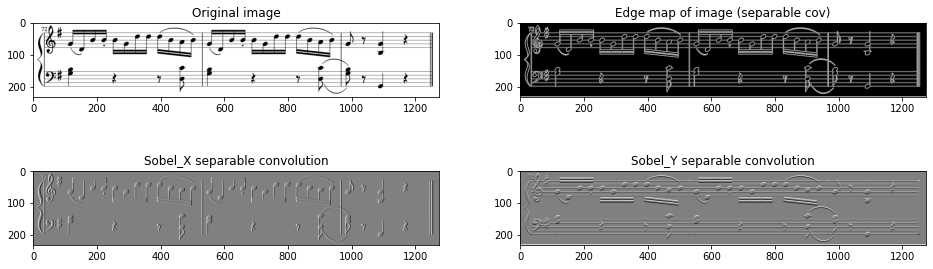

In [68]:
img_name = r"test-images\music1.png"
omr_music1 = omr(img_name, with_test=True)
_ = omr_music1.edge_detect_sobel(figsize=(16,5))
_ = omr_music1.edge_detect_sobel_separable(figsize=(16,5))

## Checking a threshold value of pixel intensity to change pixel value to 1 and 0
* Threshold = 250

INFO: Loaded test-images\music1.png as an array of shape (231, 1274)


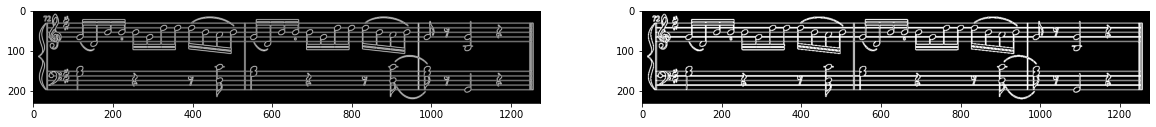

In [90]:
# img_name = r"test-images\template1.png"
img_name = r"test-images\music1.png"
omr_obj = omr(img_name, with_test=False)
edge_map = omr_obj.edge_detect_sobel_separable()
edge_map_2 = np.where(edge_map>250, 1, 0)
fig, axs = plt.subplots(1, 2, figsize=(20,16))
axs[0].imshow(edge_map, 'gray')
axs[1].imshow(edge_map_2, 'gray')

## Compare outputs of 2D convolution with separable convolution using numerical array
* The outputs match 

In [60]:
class omr2:
    def __init__(self, img_array):
        self.img_array = img_array

    def convolve(self, kernel):
        """
        Method to perform 2D convolution of self.img_array and kernel.

        Args:
            kernel (np.Array): Kernel to used for the convolution.

        Return:
            Array resulted after the convolution having shape same as input 
            image array.
        """
        kernel_rows, kernel_cols = kernel.shape
        img_rows, img_cols = self.img_array.shape

        # flip the kernel
        flipped_kernel = np.zeros(kernel.shape)    
        ## column flips
        for i in range(flipped_kernel.shape[1]):
            flipped_kernel[:,i] = kernel[:,kernel_cols-i-1]
        kernel = flipped_kernel.copy()
        ## row flips
        for i in range(flipped_kernel.shape[0]):
            flipped_kernel[i,:] = kernel[kernel_rows-i-1,:]
        kernel = flipped_kernel.copy()

        # Handle broders by padding the image with white pixels.
        padwidth = kernel_rows // 2
        self.img_array_padded = np.pad(self.img_array, padwidth, 
                                    mode='constant', constant_values=0)
        
        # cross correlation
        self.img_array_out = np.zeros(self.img_array.shape)

        for y in range(img_cols):
            for x in range(img_rows):
                self.img_array_out[x, y] = \
                (kernel * self.img_array_padded[x:x+kernel_cols, y:y+kernel_rows]).sum()

        return self.img_array_out

    def separable_convolve(self, h_kernel, v_kernel):
        """
        Method to perform 2D convolution in the horizontal and then vertical direction of self.img_array and kernel.
        Args:
            h_kernel (np.Array): Kernel used in the horizontal direction for the convolution.
            v_kernel (np.Array): Kernel used in the vertical direction for the convolution.
        Return:
            Array resulted after the convolution having shape same as input 
            image array.
        """
        kernel_rows, kernel_cols = h_kernel.shape
        img_rows, img_cols = self.img_array.shape

        # Handle broders by padding the image with white pixels.
        padwidth = kernel_cols // 2
        self.img_array_padded = np.pad(self.img_array, padwidth, 
                                    mode='constant', constant_values=0)
        
        # convoution in the horizontal direction
        self.img_array_out_tmp = np.zeros((self.img_array.shape[0]+h_kernel.shape[1]-1, self.img_array.shape[1]))
        for y in range(img_cols):
            for x in range(img_rows):
                self.img_array_out_tmp[x, y] = \
                (h_kernel * self.img_array_padded[x, y:y+h_kernel.shape[1]]).sum()

        # convoution in the horizontal direction
        self.img_array_out = np.zeros(self.img_array.shape)

        for y in range(img_cols):
            for x in range(img_rows):
                self.img_array_out[x, y] = \
                (v_kernel * self.img_array_out_tmp[x:x+v_kernel.shape[1], y]).sum()
        
        print("Convolved image:\n", self.img_array_out.shape)
        return self.img_array_out
    
A = np.array([[0,0,0,0,0],[0,16,16,16,0],[0,16,16,16,0],[0,16,16,16,0],[0,0,0,0,0]])
H = np.array([[1/16,1/8,1/16],[1/8,1/4,1/8],[1/16,1/8,1/16]])
h_kernel = np.array([[1/4,1/2,1/4]])
v_kernel = np.array([[1/4,1/2,1/4]])

omr2_obj = omr2(A)
print(omr2_obj.convolve(H))
print("*"*100)
print(omr2_obj.separable_convolve(h_kernel, v_kernel))

[[ 1.  3.  4.  3.  1.]
 [ 3.  9. 12.  9.  3.]
 [ 4. 12. 16. 12.  4.]
 [ 3.  9. 12.  9.  3.]
 [ 1.  3.  4.  3.  1.]]
****************************************************************************************************
Convolved image:
 (5, 5)
[[ 1.  3.  4.  3.  1.]
 [ 3.  9. 12.  9.  3.]
 [ 4. 12. 16. 12.  4.]
 [ 3.  9. 12.  9.  3.]
 [ 1.  3.  4.  3.  1.]]


## Calculate distance matrix

In [178]:
# A separate function to use edge maps and locate the template in the image
# Threshold 250 is decided based on visuals generated in another cell
class templateMatching:
    def __init__(self, image_edge_map, template_edge_maps):
        """
        image_edge_map = np.array - edge map of the image
        template_edge_maps = list of np.array - edge maps of all templates
        """
        self.image_edge_map = image_edge_map
        self.template_edge_maps = image_edge_map
        self.I = np.where(self.image_edge_map>250, 1, 0)
        self.D = self._image_distance_matrix()
#         self._calculate_errors(self.template_edge_maps)
        
#         self.image_rgb = 
        
    def _image_distance_matrix(self):
        """
        Returns distance matrix of the image
        """
        print("INFO: Creating distance matrix for the image.")
        self.D = np.empty(self.I.shape)
        self.D.fill(np.nan)
        I_edges = np.array(list(zip(*np.nonzero(self.I))))
        print(f"INFO: Found {len(I_edges)} edge pixels in the image.")
        
        self.D[self.I == 1] = 0
        D_nonedges = np.array(list(zip(*np.nonzero(self.D))))
        print(f"INFO: Found {len(D_nonedges)} nonedge pixels in the image.")

        for pixel in D_nonedges:
            i = pixel[0]
            j = pixel[1]
            self.D[i,j] = np.min(np.sqrt(np.sum((I_edges - pixel)**2, axis=1))) 
    
#         # Scan the image edge map
#         for i in range(self.D.shape[0]):
#             for j in range(self.D.shape[1]):
#                 if self.I[i,j] == 1:
#                     # if [i,j] is an edge pixel then distance is 0
#                     self.D[i,j] = 0
#                 else:
#                     # if [i,j] isn't an edge pixel then calculate euclidean distance 
#                     # between every edge pixel I_edges and [i,j] then take the minimum dist
#                     # which gives distance to the closest edge pixel
#                     self.D[i,j] = np.min(np.sqrt(np.sum((I_edges - np.array([i,j]))**2, axis=1)))
        print("INFO: Distance matrix created.")
        return self.D
    
    def _convolve(self, distance_matrix, template_edge_map):
        """
        Method to perform 2D convolution 
        """
        kernel_rows, kernel_cols = distance_matrix.shape
        img_rows, img_cols = image_edge_map.shape

        # flip the kernel
        flipped_kernel = np.zeros(kernel.shape)    
        ## column flips
        for i in range(flipped_kernel.shape[1]):
            flipped_kernel[:,i] = kernel[:,kernel_cols-i-1]
        kernel = flipped_kernel.copy()
        ## row flips
        for i in range(flipped_kernel.shape[0]):
            flipped_kernel[i,:] = kernel[kernel_rows-i-1,:]
        kernel = flipped_kernel.copy()

        # Handle broders by padding the image with white pixels.
        padwidth = kernel_rows // 2
        self.img_array_padded = np.pad(self.img_array, padwidth, 
                                    mode='constant', constant_values=255)
        
        # cross correlation
        self.img_array_out = np.zeros(self.img_array.shape)

        for y in range(img_cols):
            for x in range(img_rows):
                self.img_array_out[x, y] = \
                (kernel * self.img_array_padded[x:x+kernel_cols, y:y+kernel_rows]).sum()

        return self.img_array_out

    def _calculate_errors(self, template_edge_maps=None):
        if template_edge_maps == None:
            template_edge_maps = self.template_edge_maps
        for template_edge_map in template_edge_maps:
            T = np.where(template_edge_map>250, 1, 0)
            error_array = self._convolve(distance_matrix=self.D, template_edge_map=T)
            print("==============")
            print(error_array.shape)
            print(error_array)
        
        


In [165]:
img_name = r"test-images\music1.png"
template_names = [r"test-images\template1.png"]

omr_img = omr(img_name, with_test=False)
image_edge_map = omr_img.edge_detect_sobel_separable()
print("INFO: Image edge map is created with shape: ", image_edge_map.shape)

template_edge_maps = []
for t in template_names:
    omr_tmpl = omr(t, with_test=False)
    tmplate_edge_map = omr_tmpl.edge_detect_sobel_separable()
    template_edge_maps.append(tmplate_edge_map)
    print(f"INFO: Template edge map is created for {t} with shape: ", tmplate_edge_map.shape)
print(f"INFO: Total template maps created= {len(template_edge_maps)}")
    


INFO: Loaded test-images\music1.png as an array of shape (231, 1274)
INFO: Image edge map is created with shape:  (231, 1274)
INFO: Loaded test-images\template1.png as an array of shape (11, 17)
INFO: Template edge map is created for test-images\template1.png with shape:  (11, 17)
INFO: Total template maps created= 1


In [179]:
template_match = templateMatching(image_edge_map, template_edge_maps)

INFO: Creating distance matrix for the image.
INFO: Found 54971 edge pixels in the image.
INFO: Found 239323 nonedge pixels in the image.


KeyboardInterrupt: 

In [158]:
I = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])
print(I)
D = np.empty(I.shape)
D.fill(np.nan)
I_edges_x, I_edges_y = np.nonzero(I)
I_edges = np.array(list(zip(I_edges_x,I_edges_y)))

# print(D)
print(I_edges)
for i in range(D.shape[0]):
    for j in range(D.shape[1]):
        if I[i,j] == 1:
            D[i,j] = 0
        else:
            D[i,j] = np.min(np.sqrt(np.sum((I_edges - np.array([i,j]))**2, axis=1)))


print(D)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0]
 [1 1]]
[[0.         1.         1.41421356 2.23606798]
 [1.         0.         1.         2.        ]
 [1.41421356 1.         1.41421356 2.23606798]
 [2.23606798 2.         2.23606798 2.82842712]]


In [180]:
I = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,0],[0,0,0,0]])
print(I)
D = np.empty(I.shape)
D.fill(np.nan)
I_edges_x, I_edges_y = np.nonzero(I)
I_edges = np.array(list(zip(I_edges_x,I_edges_y)))

# print(D)
# print(I_edges)

D[I == 1] = 0
D_nonedges = np.array(list(zip(*np.nonzero(D))))
# print(D_nonedges)

D[I == 0] =  np.min(np.sqrt(np.sum((I_edges - D)**2, axis=1)))


# for pixel in D_nonedges:
#     i = pixel[0]
#     j = pixel[1]
#     D[i,j] = np.min(np.sqrt(np.sum((I_edges - pixel)**2, axis=1)))
    
# D[I == 0] = 
# for i in range(D.shape[0]):
#     for j in range(D.shape[1]):
#         if I[i,j] == 1:
#             D[i,j] = 0
#         else:
#             D[i,j] = np.min(np.sqrt(np.sum((I_edges - np.array([i,j]))**2, axis=1)))


print(D)
# print(np.nonzero(D))

[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 0]
 [0 0 0 0]]


ValueError: operands could not be broadcast together with shapes (2,2) (4,4) 

In [153]:
# print(
#     np.min(np.sqrt(np.sum((I_edges - np.array([0,3]))**2, axis=1)))
# )

print(I_edges)
print(
   np.min(np.sqrt(np.sum((I_edges - np.array([0,2]))**2, axis=1)))
)

[[0 0]
 [1 1]]
1.4142135623730951
